In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
data = pd.read_csv('https://impfdashboard.de/static/data/germany_deliveries_timeseries_v2.tsv', sep='\t')

In [3]:
data['date'] = pd.to_datetime(data.date)
data['week'] = data.date.apply(lambda x: x.week)
data.tail()


,date,impfstoff,region,dosen,week
886,2021-05-04,johnson,DE-SH,7200,18
887,2021-05-04,johnson,DE-TH,4800,18
888,2021-05-08,comirnaty,DE-BUND,35100,18
889,2021-05-07,moderna,DE-BUND,30000,18
890,2021-05-04,johnson,DE-BUND,24600,18


In [4]:
g = data.groupby(['date', 'impfstoff', 'week']).sum().reset_index().sort_values('date')

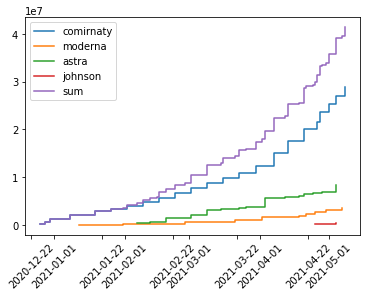

In [5]:
for i in g.impfstoff.unique():
    #i = 'comirnaty'
    g_supplier = g[g.impfstoff == i].copy()
    plt.step(g_supplier.date, g_supplier.dosen.cumsum(), where='post', label=i)

g_total = data.groupby('date').sum().reset_index().sort_values('date')
g_total['date'] = pd.to_datetime(g_total.date)
g_total.loc[:,'c'] = g_total.dosen.cumsum()
plt.step(g_total.date, g_total.c, where='post', label='sum')

plt.ticklabel_format(useOffset=False, style='sci', axis='y')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [6]:
weekly = g.groupby(['week', 'impfstoff'])
weekly = pd.DataFrame({'date': weekly.date.min(), 'dosen': weekly.dosen.sum()}).reset_index().sort_values('date')


In [7]:
all_weeks = pd.Series([pd.to_datetime('2020-12-14')+timedelta(weeks=x) for x in range(39)])
all_week_starts = all_weeks.apply(lambda x: x.week)

all_weeks = pd.DataFrame({'date': all_weeks, 'week': all_week_starts})

for i in weekly.impfstoff.unique():
    all_weeks = all_weeks.merge(weekly[weekly.impfstoff == i], on='week', how='left', suffixes=[None, '_'+i])


weekly_shipments = pd.DataFrame({'date': all_weeks.date, 'Week': all_weeks.week, 'BNT/Pfizer': all_weeks.dosen, 'Moderna': all_weeks.dosen_moderna, 'Oxford/AZ': all_weeks.dosen_astra, 'Janssen/J&J': all_weeks.dosen_johnson})
weekly_shipments.head()

,date,Week,BNT/Pfizer,Moderna,Oxford/AZ,Janssen/J&J
0,2020-12-14,51,NaN,NaN,NaN,NaN
1,2020-12-21,52,151125.0,NaN,NaN,NaN
2,2020-12-28,53,1174875.0,NaN,NaN,NaN
3,2021-01-04,1,687375.0,NaN,NaN,NaN
4,2021-01-11,2,NaN,63600.0,NaN,NaN


In [8]:
total_shipments = weekly_shipments.sum()/1000000.0

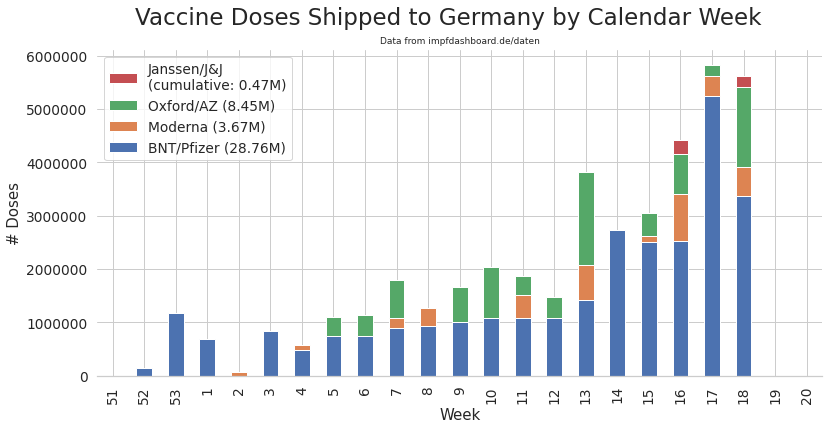

In [9]:
print('')
print('')
print('')
sns.set(font_scale=1.25)
sns.set_style("whitegrid")
ax = weekly_shipments[['Week', 'BNT/Pfizer', 'Moderna', 'Oxford/AZ', 'Janssen/J&J']].head(23).set_index('Week').plot(kind='bar', stacked=True, figsize=(13,6))
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.ylabel('# Doses')
sns.despine(left=True)

plt.suptitle('Vaccine Doses Shipped to Germany by Calendar Week', fontsize=23)
plt.title('Data from impfdashboard.de/daten', fontsize=9)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), [l + (f'\n(cumulative: {total_shipments[l]:.2f}M)') if l == 'Janssen/J&J' else l + f' ({total_shipments[l]:.2f}M)' for l in reversed(labels)], loc='upper left')

plt.show()
print('')
print('')
print('')